# Machine Learning - Classification

This module, we'll talk about another class of problems we can solve with machine learning. Classification is a subcategory of supervised learning where the goal is to predict the categorical class labels of new instances based on past observations.

Generally, there are 2 main types of classification problems:
- Binary: classifying  into 2 classes. (i.e., Spam and not-spam)
- Multi-class classification: classifying into multiple classes. (i.e., images of handwritten character recognition)

in it's simplest formats, the objective is to find a line or a plane that segregates the data points into different classes.
![simple classification](./assets/simple-classification.png)

In [93]:
# in this cell, we'll import all the libraries and packages we'll need in this tutorial.

# Python ≥3.10 is required
import sys
assert sys.version_info >= (3, 10)

# Common imports
import numpy as np
import pandas as pd
import pandas_profiling
import os

# Scikit Learn imports
from sklearn.preprocessing import (
  OneHotEncoder,
  OrdinalEncoder,
  StandardScaler
)
from sklearn.impute import (
  SimpleImputer
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
  StratifiedShuffleSplit,
  train_test_split,
  cross_val_score,
  KFold,
  GridSearchCV
)
from sklearn.compose import ColumnTransformer

# Classifier Algorithms
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import pickle

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use("bmh")

# to make this notebook's output stable across runs
np.random.seed(42)

## Titanic Survival
In this tutorial we'll use the titanic dataset from [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/). We will use to train a model that classifies passengers based on whether or not they've survived. The objective would be to develop a model that would predict survival based on other features and attributes.

We'll start with importing the dataset from `data/titanic.csv`, and printing samples of the data.

In [94]:
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


We see that we have the following features, this info was provided on the [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/).

| Feature     | Description                                                                                             |
| ----------- | ------------------------------------------------------------------------------------------------------- |
| `pclass`    | Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd). This can be considered as proxy for socio-economic status. |
| `survived`  | Survival (0 = No; 1 = Yes)                                                                              |
| `name`      | Name                                                                                                    |
| `sex`       | Sex                                                                                                     |
| `age`       | Age                                                                                                     |
| `sibsp`     | Number of Siblings/Spouses Aboard                                                                       |
| `parch`     | Number of Parents/Children Aboard                                                                       |
| `ticket`    | Ticket Number                                                                                           |
| `fare`      | Passenger Fare                                                                                          |
| `cabin`     | Cabin                                                                                                   |
| `embarked`  | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)                                    |
| `boat`      | Lifeboat (if survived)                                                                                  |
| `body`      | Body number (if did not survive and body was recovered)                                                 |
| `home.dest` | Home/Destination                                                                                        |

## Prepare - Some EDA
Let's do some exploratory data analysis to get a better understanding of the data. 

In [95]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


let's visualize the histogram of the data to see the distribution of the data.

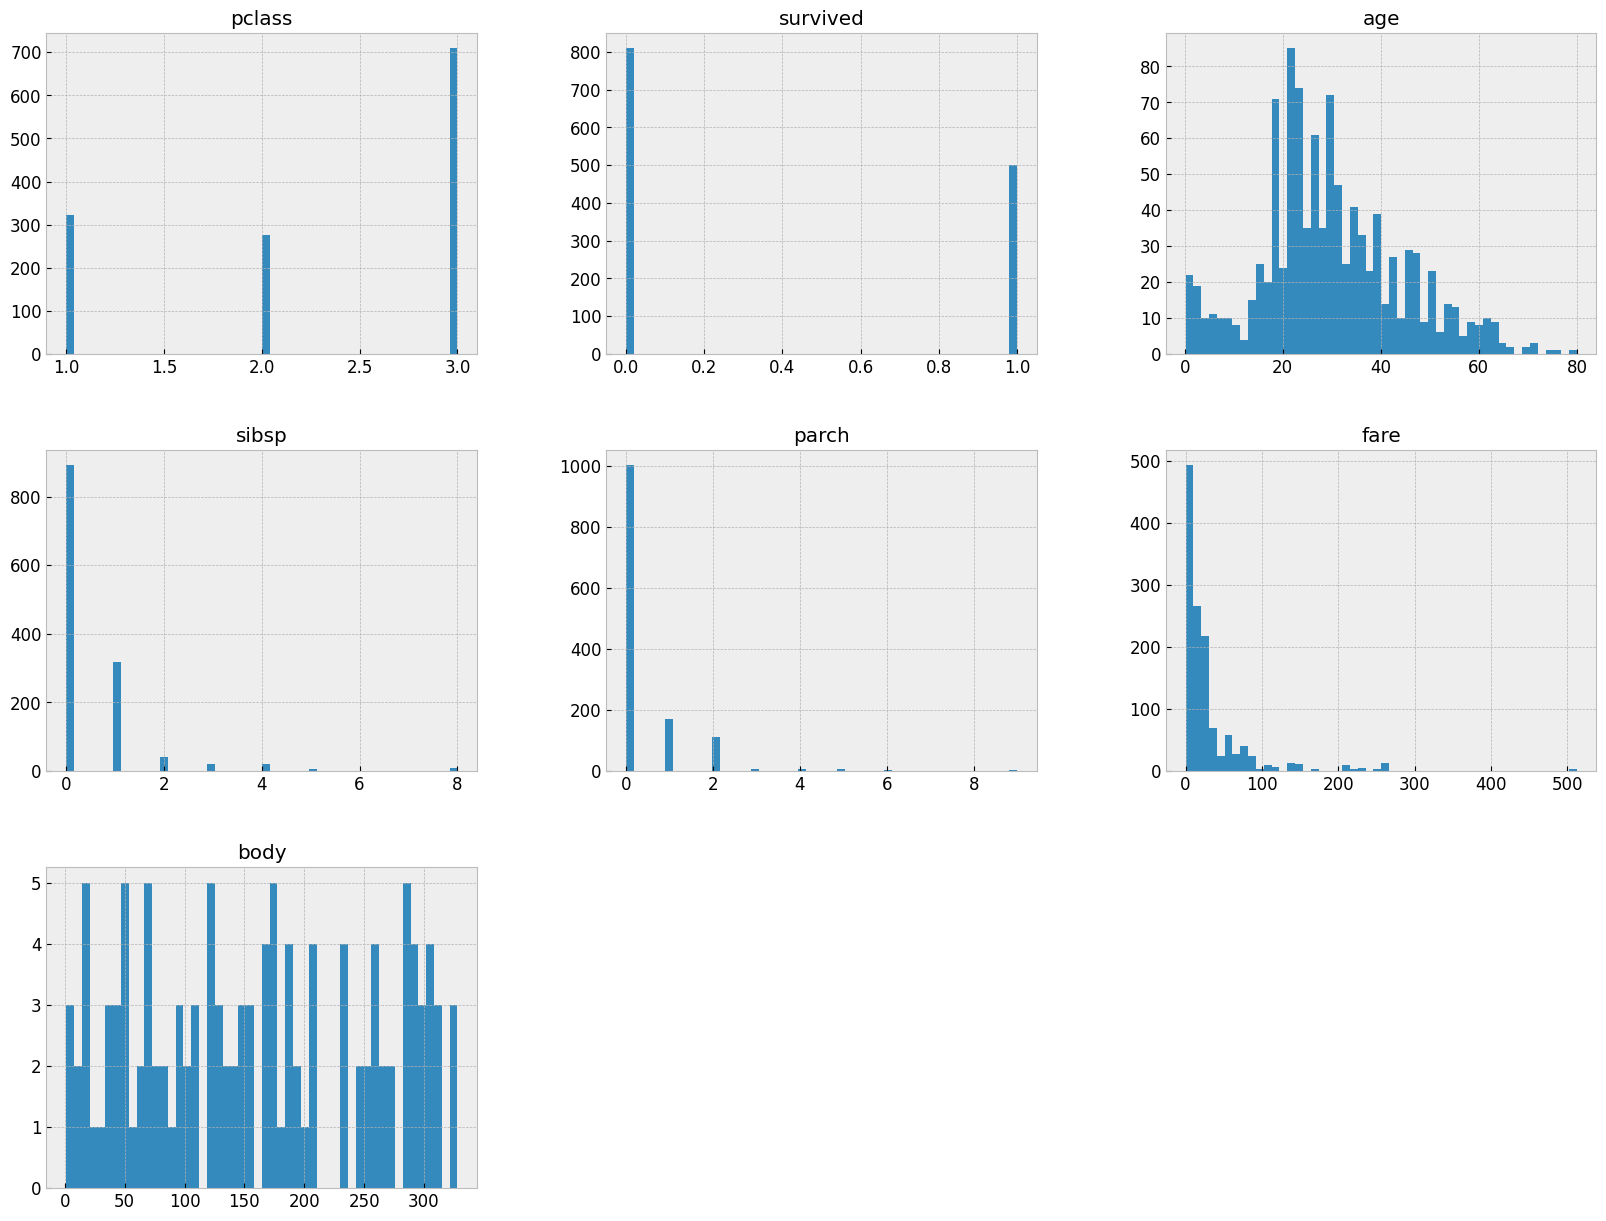

In [96]:
# REMEMBER: number of bins indicate the number if intervals we want to divide our data into
titanic.hist(bins=50, figsize=(20,15))
plt.show()

> 🦉 **Note**: Take a moment and try to make some observations based on the above before you continue reading the below.

We can observer the following:

- Most of the passengers were in the 3rd class.
- `survived` is the target variable, and we can see that most of the passengers did not survive.
- Majority of passengers were traveling alone (no siblings or spouses, no parents or children).
- There's a lot of missing data in the `cabin`, and `age` columns.
- `pclass`, `sex`, `embarked` are categorical variables.

| Column     | Type                                          | notes                                                                                                                                   |
| ---------- | --------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------- |
| pclass     | categorical - ordinal                         |                                                                                                                                         |
| name       | string - would this be valuable to our model? |                                                                                                                                         |
| sex        | categorical - nominal                         |                                                                                                                                         |
| age        | numerical - continuous                        | the reason why it's not discrete, is that we see the column type set to float64, and some of the values are 0.92 (less than a year old) |
| sibsp      | numerical - discrete                          |                                                                                                                                         |
| parch      | numerical - discrete                          |                                                                                                                                         |
| ticket     | string - would this be valuable to our model? |                                                                                                                                         |
| fare       | numerical - continuous                        |                                                                                                                                         |
| cabin      | _(Quiz Question)_                             |                                                                                                                                         |
| embarked   | Categorical - could be ordinal or nominal     | Do we think people who boarded first, had better chances of survival?                                                                   |
| boat       | string                                        | boat identifier                                                                                                                         |
| body       | numerical (or string)                         | body ID                                                                                                                                 |
| home. dest |                                               |                                                                                                                                         |
| survived   | category _(ordinal, or nominal?)_             |                                                                                                                                         |

- we also realize that both `boat` and `body` are what we call **Leaky Features**. These are features that kind of gives the answer about the future. Having a `body` number, means they didn't survive. These are features that are not available at the time of prediction, and therefore should not be used in the model. We'll drop these features later on.


**how about missing values?**

In [97]:
titanic.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

We will need to impute the missing values in the Age column.

**BUT** we shouldn't do any of that until the data is split into training and test sets. We don't want to introduce any bias into the data.

Let me show another interesting library called `pandas_profiling`. This library will generate a report of the data, and it's very useful for exploratory data analysis.

if you don't already have it installed, you can install it with `pipenv install pandas-profiling ipywidgets`.

> 🦉 **Note**: The report looks like a webpage embedded in the notebook, if you're using Jupyter Lab or VSCode. It may look a bit different if you're viewing this directly on GitHub.

In [98]:
# pandas_profiling.ProfileReport(titanic, title='Pandas Profiling Report')

The generated report is able, to a high degree of correctness, to detect the data types of the columns, and also detect missing values.
It's able to show the distribution of the data, and also the correlation between the features.

Before we proceed any further, and before we start cleaning, the data, dropping columns, or anything else, we need to split the data into training and test sets.

____________________

## Prepare - Data Splitting

- should we stratify or not?
With large datasets, stratified sampling is a good idea. This is because we want to make sure that the training and test sets have the same distribution of the target variable.

in talking with a hypothetical subject-matter expert (SME), they mentioned that when splitting the data, we need:
- all passenger classes needs to be represented in the dataset with the same frequency as they appear in the original dataset.
- They also had a theory that the `embarked` column may have some effect  SME suggested that we should use `embarked` as the stratification feature.

Another SME suggested that `sex` is a more important feature to startify the data split on, and that we should use that instead.

```python
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=56)

for train_index, test_index in split.split(titanic, titanic['embarked']):
  strat_train_set = titanic.loc[train_index]
  strat_test_set = titanic.loc[test_index]
```


In [99]:
train_set, test_set = train_test_split(titanic, test_size= 0.2, random_state=45)

Let's also separate the features from the labels

In [100]:
titanic_X = train_set.drop('survived', axis=1)
titanic_y = train_set['survived'].copy()

_______________________

## Process - Data Cleaning
### Dropping Features
We generally drop columns that have no signal, or no variance, or not useful for the model. We also drop columns that are **Leaky Features**.

* `name` column
  - unless we're doing some fancy Natural Language Processing (NLP), or we have some theory about the names may have an effect on the survival rate, (like easier names were easier to remember and call out, and therefore easier to save 🤷‍♂️),  we can drop the `name` column.
* `ticket` column
  - we can drop the `ticket` column, because it's just a ticket number, and it's not going to be useful for the model.
* `boat` column
  - we can drop the `boat` column, because it's a leaky feature. if you got on a boat, you survived (very likely).
* `body` column
  - we can drop the `body` column, because it's a leaky feature. If you have a body number, you didn't survive.
* `home.dest` column
  - we can drop the `home.dest` column, because it's not going to be useful for the model.
* `cabin` column
  - we can drop the `cabin` column, because it's missing 77,5% of the data, and imputing it wouldn't not be effective.


> 🦉 **Remember**: we separated the dataset into training and test sets, if we're going to drop the columns from one, we're going to remove from the other as well.

Previously, we used the `.drop()` method to drop the columns. and we had to call it twice, once for the training set, and once for the test set.

```python
train_set.drop(['name', 'ticket', 'boat', 'body', 'home.dest'], axis=1, inplace=True)
test_set.drop(['name', 'ticket', 'boat', 'body', 'home.dest'], axis=1, inplace=True)
```

But we've also learned about creating a pipeline. Pipelines allow us to chain together multiple transformations that we can apply to both the training and test sets. 

If you remember, we have used the `ColumnTransformer` before to apply different transformation to the *Numerical* and *Categorical* features. I will also use it this week to drop columns as well.

**We can use the `ColumnTransformer` to drop columns.**

So let's start by creating our full pipeline that we'll use in the data cleaning process.

In [101]:
drop_columns = ['name', 'ticket', 'boat', 'body', 'home.dest', 'cabin']

full_pipeline = ColumnTransformer([
  ('drop_columns', 'drop', drop_columns),
], remainder='passthrough')

> ** 🦉 **Remember**: Note because the last (technically the only) transformer in the pipeline is not a transformer that supports `fit` and `transform` methods, but a special-cased string, we need to use the `passthrough` keyword for the remainder of data going through the pipeline. [📜 Learn more about this here](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

to execute the pipeline, we'll use the `fit_transform()` method. This method will execute the pipeline, and return the transformed data as a numpy n-dimensional array.

In [102]:
# Apply the Transformation
transformed_train_set = full_pipeline.fit_transform(titanic_X)

# Transform the numpy n-dimensional array into a pandas dataframe
transformed_train_set = pd.DataFrame(transformed_train_set, columns=titanic_X.columns.drop(drop_columns), index=titanic_X.index)
transformed_train_set.head()

,pclass,sex,age,sibsp,parch,fare,embarked
801,3,male,NaN,0,0,7.75,Q
361,2,female,22.0,1,1,29.0,S
440,2,female,48.0,1,2,65.0,S
523,2,male,22.0,0,0,10.5,S
1158,3,female,41.0,0,2,20.2125,S


### Imputing Missing Values
#### The Why...
Imputing missing values is a very important step in the data cleaning process. We can't just drop the rows with missing values, because we'll lose a lot of data. Instead we calculate a value that will replace the missing value. This value is called the **Imputed Value**.

Even if there was no missing values in the training set, there may be missing values in the test set, or in new data points. So we need to make sure that we do the imputation when building the training set the imputation is done on both the training and test sets.

#### The How...
Generally, we use the `median` value to impute missing values , because it's not affected by outliers. But we can also use the mean value, or the most frequent value.

We can use the `mean` and `median` with numerical features, and the `most_frequent` with numerical and categorical features. [📜 Learn more about this here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

so looks like we need a different imputer for each type of feature (numerical and categorical). So let's let's create 2 lists of feature names, one for numerical features, and one for categorical features. each set will use a different pipeline and a different imputer. 

In [103]:
num_features = ['age', 'sibsp', 'parch', 'fare']
cat_features = ['pclass', 'sex', 'embarked']

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='median'))
])

cat_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent')),
])

# modified the previous `full_pipeline` to include the `num_pipeline` and `cat_pipeline`
full_pipeline = ColumnTransformer([
  ('drop_columns', 'drop', drop_columns),
  ('num', num_pipeline, num_features),
  ('cat', cat_pipeline, cat_features)
])

**Detour - not really** 

If we use the same cell to print out the result of the new transformation, we'll notice the column names are not in the correct order anymore.

Check out the `fare` column for example to realize what's happened.

In [104]:
# Apply the Transformation
transformed_train_set = full_pipeline.fit_transform(titanic_X)

# Transform the numpy n-dimensional array into a pandas dataframe
transformed_train_set = pd.DataFrame(transformed_train_set, columns=titanic_X.columns.drop(drop_columns), index=titanic_X.index)
transformed_train_set.head()

,pclass,sex,age,sibsp,parch,fare,embarked
801,28.0,0.0,0.0,7.75,3,male,Q
361,22.0,1.0,1.0,29.0,2,female,S
440,48.0,1.0,2.0,65.0,2,female,S
523,22.0,0.0,0.0,10.5,2,male,S
1158,41.0,0.0,2.0,20.2125,3,female,S


The pipeline reorders the features in the order provided in the `ColumnTransformer` for the `num_pipeline` and `cat_pipeline`

to get the list of the features in the new order, we can use the `get_feature_names_out()` method on the `full_pipeline`

In [105]:
full_pipeline.get_feature_names_out()

array(['num__age', 'num__sibsp', 'num__parch', 'num__fare', 'cat__pclass',
       'cat__sex', 'cat__embarked'], dtype=object)

Note how the pipeline prefixes the feature names with the name of the pipeline

To get a list of the original features names  in the new order, I will use a technique called **List Comprehension** to construct a new list based on looping over the new names and removing the prefix with the `replace` function.

In [106]:
column_names = [ 
  feature.replace('num__', '').replace('cat__', '') 
  for feature in full_pipeline.get_feature_names_out()
]
column_names

['age', 'sibsp', 'parch', 'fare', 'pclass', 'sex', 'embarked']

Let's run the transformation and conversion cell again, and see the result.

Here we'll update the columns property provided to the `DataFrame` constructor to use the new list of feature names.

In [107]:
# Apply the Transformation
transformed_train_set = full_pipeline.fit_transform(titanic_X)

# Transform the numpy n-dimensional array into a pandas dataframe
transformed_train_set = pd.DataFrame(transformed_train_set, columns=column_names, index=titanic_X.index)
transformed_train_set.head()

,age,sibsp,parch,fare,pclass,sex,embarked
801,28.0,0.0,0.0,7.75,3,male,Q
361,22.0,1.0,1.0,29.0,2,female,S
440,48.0,1.0,2.0,65.0,2,female,S
523,22.0,0.0,0.0,10.5,2,male,S
1158,41.0,0.0,2.0,20.2125,3,female,S


to prove that no missing values exist anymore:

In [108]:
transformed_train_set.isnull().sum()

age         0
sibsp       0
parch       0
fare        0
pclass      0
sex         0
embarked    0
dtype: int64

## Standardization and Normalization
### The Why...
We need to standardize the numerical features, because we want to make sure that the features are on the same scale. If we don't do this, the features with a higher scale will have a higher weight in the model.

Not all models require this step, decision trees for example, don't require this step. But we're going to use other models as well, so we'll do this for good measure.

### The How...
We can use the `StandardScaler` to standardize the numerical features. [📜 Learn more about this here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

This is only applied to numerical features. It can be applied to categorical features as well, but it's not recommended, categorical features don't necessarily follow a normal distribution.

We will need to modify the pipeline to add this step to numerical pipeline.

In [109]:
num_features = ['age', 'sibsp', 'parch', 'fare']
cat_features = ['pclass', 'sex', 'embarked']

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='median')),
  ('scale', StandardScaler())
])

cat_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent')),
])

# modified the previous `full_pipeline` to include the `num_pipeline` and `cat_pipeline`
full_pipeline = ColumnTransformer([
  ('drop_columns', 'drop', drop_columns),
  ('num', num_pipeline, num_features),
  ('cat', cat_pipeline, cat_features)
])

### Handling Categorical Features
As we've mentioned before, we deal with categorical features in 2 ways:
1. Ordinal Encoding - for Ordinal features - features that have a natural order, or ranking. (like `pclass` for example)
2. One-Hot Encoding - for Nominal features - features that don't have a particular order, or ranking. (like `sex` for example)

> **Interesting Thought 🧠🧐**: Could the point of passenger embarkation have an effect on their chances of survival? How you answer this question will determine how you encode this feature.
> Passengers boarded the Titanic in 3 different ports: Southampton, England,  then Cherbourg, France, and Finally Queenstown, Ireland.
> - If you think that the point of embarkation has no effect on the chances of survival, then this piece of information is a nominal data, then you can use One-Hot Encoding.
> - If you think that having boarded the Titanic earlier, or later, has an effect on the chances of survival, For example, having boarded early, passengers may have gotten better at getting around the ship and know faster paths to the lifeboats, then this piece of information is an ordinal data, then you can use Ordinal Encoding.
> - If you think that passengers at different points of embarkation were given different information, and given better training at the different ports (so it's not the order that matter but rather the location itself), then this would be a nominal data, then you can use One-Hot Encoding.

We will need to modify the pipeline to handle the different categorical data differently.

In [110]:
num_features = ['age', 'sibsp', 'parch', 'fare']
cat_features = ['pclass', 'sex', 'embarked']
ordinal_cat_features = ['pclass']
nominal_cat_features = [ 'sex', 'embarked']

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='median')),
  ('scale', StandardScaler())
])

ordinal_cat_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('encode', OrdinalEncoder())
])

nominal_cat_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('encode', OneHotEncoder())
])

# modified the previous `full_pipeline` to include the `num_pipeline` and `cat_pipeline`
full_pipeline = ColumnTransformer([
  ('drop_columns', 'drop', drop_columns),
  ('num', num_pipeline, num_features),
  ('ordinal_cat', ordinal_cat_pipeline, ordinal_cat_features),
  ('nominal_cat', nominal_cat_pipeline, nominal_cat_features)
])

Let's apply the transformation and conversion cell again, and see the result.

In [111]:
# Apply the Transformation
transformed_train_set = full_pipeline.fit_transform(titanic_X)

# Get the new column names after the new transformations
column_names = [ 
  feature
    .replace('num__', '')
    .replace('cat__', '') 
    .replace('ordinal_', '') 
    .replace('nominal_', '') 
  for feature in full_pipeline.get_feature_names_out()
]
display(column_names)

# Transform the numpy n-dimensional array into a pandas dataframe
transformed_train_set = pd.DataFrame(transformed_train_set, columns=column_names, index=titanic_X.index)
transformed_train_set.head()

['age',
 'sibsp',
 'parch',
 'fare',
 'pclass',
 'sex_female',
 'sex_male',
 'embarked_C',
 'embarked_Q',
 'embarked_S']

,age,sibsp,parch,fare,pclass,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
801,-0.106890,-0.469588,-0.441078,-0.486942,2.0,0.0,1.0,0.0,1.0,0.0
361,-0.578548,0.481396,0.728058,-0.063742,1.0,1.0,0.0,0.0,0.0,1.0
440,1.465301,0.481396,1.897193,0.653210,1.0,1.0,0.0,0.0,0.0,1.0
523,-0.578548,-0.469588,-0.441078,-0.432175,1.0,0.0,1.0,0.0,0.0,1.0
1158,0.915034,-0.469588,1.897193,-0.238748,2.0,1.0,0.0,0.0,0.0,1.0


One thing we should note is that the `sex_female` and `sex_male` columns are mutually exclusive. only one of them can be `1` at a time. This is called a **Dummy Variable Trap**. We can drop one of the columns to avoid this trap.

In [112]:
clean_titanic_X = transformed_train_set.drop('sex_female', axis=1).rename(columns={ 'sex_male': 'is_male' })
clean_titanic_X.head()

,age,sibsp,parch,fare,pclass,is_male,embarked_C,embarked_Q,embarked_S
801,-0.106890,-0.469588,-0.441078,-0.486942,2.0,1.0,0.0,1.0,0.0
361,-0.578548,0.481396,0.728058,-0.063742,1.0,0.0,0.0,0.0,1.0
440,1.465301,0.481396,1.897193,0.653210,1.0,0.0,0.0,0.0,1.0
523,-0.578548,-0.469588,-0.441078,-0.432175,1.0,1.0,0.0,0.0,1.0
1158,0.915034,-0.469588,1.897193,-0.238748,2.0,0.0,0.0,0.0,1.0


> I couldn't do the above un the pipeline. Not sure if it's possible.

at this point, we have a clean dataset that we can use to train our model. Remember, the machine learning model development process is an iterative one. We can also come back to this step and add more transformations. For example, we can add a new transformation to handle outliers, we can introduce new features, or we can drop features that we think are not useful.

In [113]:
display(clean_titanic_X.shape)
display(titanic_y.shape)

(1047, 9)

(1047,)

__________________________

## Analyze
At this step, we'll work on developing multiple models, and then select the best one. We'll use the `clean_titanic_X` ro train the model, and do some initial evaluation of the model accuracy and performance. Once we're satisfied with the results we're getting, we'll the test set to evaluate the model and ensure that's it's not overfitting, or underfitting.

![Model Evaluation](./assets/evaluate-model.webp)

One Approach I've seen in classification problems, is to use a *Dummy Classifier* as a baseline. This is a classifier that makes predictions without considering the input. The predictions can be random, based on the most frequent class in the dataset, ... etc.

[📜 Learn more: Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)

### Dummy Classifier
This is a good baseline to compare our model to. If our model is better than the dummy classifier, then we know that we're on the right track.

Let's start with that.

In [114]:
# imported DummyClassifier and the metrics packages (first cell)
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(clean_titanic_X, titanic_y)
dummy_classifier.score(clean_titanic_X, titanic_y) # accuracy

0.5071633237822349

In [115]:
dummy_classifier.predict(clean_titanic_X)

array([0, 1, 0, ..., 1, 0, 0])

> Try different strategies for the dummy classifier, and see how it affects the results.

Remember in previous modules, we talked about using the cross-validation technique to evaluate the model. We'll use the same technique here.

[📜 Learn more: SkLearn-cross validation](https://scikit-learn.org/stable/modules/cross_validation.html)

Similar to how we used the `train_test_split` function to split the data into training and test sets, we'll use the `cross_val_score` function to split the training data into training and validation sets, and then evaluate the model on each of the validation sets.

[📜 Learn more: `cross_val_score` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

Let's apply that to our dummy classifier. 

In [116]:
scores = cross_val_score(
  dummy_classifier, clean_titanic_X, titanic_y,
  scoring="roc_auc", cv=10)
print(
    f"Dummy Classifier  AUC: {scores.mean():.3f} STD: {scores.std():.2f}"
)

Dummy Classifier  AUC: 0.495 STD: 0.04


Similar to when we learned about linear regression, I've mentioned that we use the mean squared errors to calculate the RMSE, the model's effectiveness, in classification problems, we use the (Area Under Curve) AUC to calculate the ROC AUC.

AUC is a good metric to use for classification problems. It's a measure of how well the model can distinguish between the positive and negative classes. The higher the AUC, the better the model is at distinguishing between the positive and negative classes.

- [📜 Learn more about this here: Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)
- [📜 Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

### Logistic Classifier


In [117]:
logistic_classifier = LogisticRegression()
logistic_classifier.fit(clean_titanic_X, titanic_y)

LogisticRegression()

In [118]:
scores = cross_val_score(
  logistic_classifier, clean_titanic_X, titanic_y,
  scoring="roc_auc", cv=10)
print(
    f"Logistic Classifier  AUC: {scores.mean():.3f} STD: {scores.std():.2f}"
)

Logistic Classifier  AUC: 0.848 STD: 0.05


For the `cross_val_score` funciton, the scoring is selected such that the higher the score, the better the model is. So, we'll use the `roc_auc_score` function to calculate the AUC score.

From the above we see that logisitic regression is better than the dummy classifier. (higher AUC value).

Now let's try to be a bit more efficient, and test out multiple models at once. The process is the same for all models, we fit, ane use the `cross_val_score` function to evaluate the model.

We'll test the following: 
- DummyClassifier,
- LogisticRegression,
- DecisionTreeClassifier,
- KNeighborsClassifier,
- GaussianNB,
- SVC,
- RandomForestClassifier,
- xgboost.XGBClassifier,

The following will run the models, without any hyperparameter tuning (default/out-of-the-box configurations).

In [119]:
for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
]:
    classifier_model = model()
    # defining the kfolds, will ensure that all models will be trained with the same data
    kfold = KFold(
        n_splits=10, random_state=42, shuffle=True
    )
    scores = cross_val_score(
        classifier_model,
        clean_titanic_X, 
        titanic_y, 
        scoring="roc_auc", cv=kfold
    )
    print(
    f"{model.__name__:22}  AUC: {scores.mean():.3f} STD: {scores.std():.2f}"
)

DummyClassifier         AUC: 0.500 STD: 0.00
LogisticRegression      AUC: 0.849 STD: 0.03
DecisionTreeClassifier  AUC: 0.750 STD: 0.04
KNeighborsClassifier    AUC: 0.823 STD: 0.04
GaussianNB              AUC: 0.814 STD: 0.04
SVC                     AUC: 0.845 STD: 0.03
RandomForestClassifier  AUC: 0.846 STD: 0.04


Now we've mentioned that a good model would be the one that has a high AUC score, but here I also want to add that we may go with an algorithm that has a slightly smaller score but tighter standard deviation. This means that the model is more consistent, and less likely to overfit.

from the results above, looks like the Logistic Regression, SVC and RandomForestClassifier are the best models. Let's evaluate them using the test set.

**Remember**: our baseline for choosing the best model was the dummy classifier, and the AUC scores.

> **🦉 Note**: Understanding the different hyperparameters of each model is important. However it's well-outside the scope of this course. However, you can always start with the sklearn documentation for each model to get an idea of the different hyperparameters and their usages.

In [120]:
# Bringing back the logistic classifier
logistic_classifier = LogisticRegression()
logistic_classifier.fit(clean_titanic_X, titanic_y)

scores = cross_val_score(
  logistic_classifier, clean_titanic_X, titanic_y,
  scoring="roc_auc", cv=10)
print(
    f"Logistic Classifier  AUC: {scores.mean():.3f} STD: {scores.std():.2f}"
)

Logistic Classifier  AUC: 0.848 STD: 0.05


In addition to the AUC score, there are other metrics that we can use to evaluate a model.


The following resource explains most of those metrics.
- [📜 Learn more about this here: Understanding Classification Metrics in Sklearn](https://towardsdatascience.com/understanding-classification-metrics-in-scikit-learn-in-python-3bc336865019)

I will show:
- `.score` method,
  - this returns the mean accuracy of the given X, and y.(prediction accuracy).
- `precision_score`
  - this returns the ration of the true positives to the sum of the true positives and false positives. $\frac{tp}{(tp+fp)}$
- `confusion_matrix`,
  - this returns the confusion matrix which is a table that shows the number of true positives, true negatives, false positives, and false negatives.



In [121]:
# `.score` on training data
logistic_classifier.score(clean_titanic_X, titanic_y)

0.7965616045845272

In [122]:
# `precision_score` on training data
metrics.precision_score(titanic_y, logistic_classifier.predict(clean_titanic_X))

0.7493333333333333

In [123]:
# Confusion Matrix
metrics.confusion_matrix(titanic_y, logistic_classifier.predict(clean_titanic_X))

array([[553,  94],
       [119, 281]])

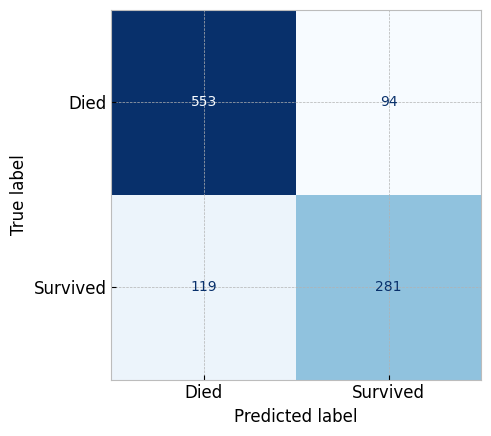

In [124]:
# plotting the confusion matrix
## the metrics packages has a `plot_confusion_matrix` function
metrics.ConfusionMatrixDisplay.from_estimator(
  estimator=logistic_classifier,
  X=clean_titanic_X, y=titanic_y,
  display_labels=['Died', 'Survived'],
  cmap="Blues", colorbar=False
)
plt.show()

We can attribute the inaccuracy of the model to either that model is not a good fit for the data (underfitting), or that we don't have enough data to train the model.

For this particular problem, those scores can be considered good enough. However, we can still improve the model by tuning the hyperparameters.

Looking at the documentation for the `LogisticRegression` model, we can see that there are a lot of hyperparameters that we can tune. [📜 LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score). finding the best combination of the matrix that would get us the best outcome can be a very tedious process. especially with this number of parameters. *However,* We can use the `GridSearchCV` function to find the best combination of hyperparameters.

[📜 Learn more about this here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)


In [125]:
# first we define the different options for each of the hyperparameters
param_grid = {
  'penalty': ['l2'],
  'C': [ 100, 10, 1, 0.1, 0.01, 0.001],
  'solver': ['liblinear', 'lbfgs', 'newton-cg']
}

# then we define the grid search
grid_search = GridSearchCV(
  estimator=LogisticRegression(),
  param_grid=param_grid,
  n_jobs=-1,
  scoring='roc_auc',
).fit(clean_titanic_X, titanic_y)
print(f"Best Score: {grid_search.best_score_}")
print(f"Best Params: {grid_search.best_params_}")

Best Score: 0.8477857036374479
Best Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Looks like we were able to find a better combination of hyperparameters.

if we're curious to see the results of the other combinations, we can do the following:

In [126]:
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.847426 (0.025140) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.847464 (0.025137) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.847464 (0.025137) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.847387 (0.025229) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.847368 (0.025135) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.847368 (0.025135) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.847330 (0.025299) with: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
0.847175 (0.025162) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.847175 (0.025162) with: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.847786 (0.025439) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.846199 (0.025769) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.846199 (0.025769) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832383 (0.029007) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.831354 (0.028107) wit

Let's generate the confusion matrix for this new model

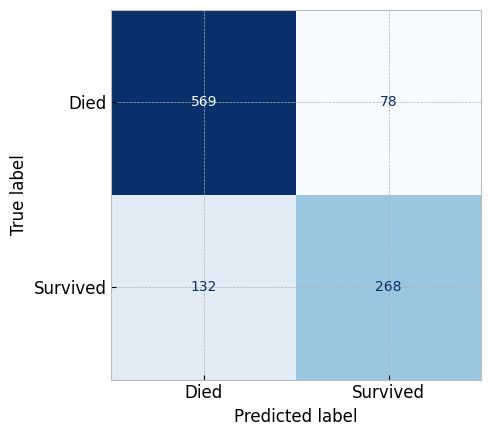

In [127]:
# First create the new model with the best parameters
updated_logistic_classifier = LogisticRegression(
  C=0.1, penalty='l2', solver='liblinear'
)
# Then fit the model
updated_logistic_classifier.fit(clean_titanic_X, titanic_y)

# Then plot the confusion matrix
metrics.ConfusionMatrixDisplay.from_estimator(
  estimator=updated_logistic_classifier,
  X=clean_titanic_X, y=titanic_y,
  display_labels=['Died', 'Survived'],
  cmap="Blues", colorbar=False
)
plt.show()

 Let's evaluate the model using the test set.

 **Remember**, now that we have a model, our baseline for evaluating the model are the metrics on training set, compared to the metrics on the test set.

In [128]:
# EVALUATION ON TEST SET
# First we need to transform the test set
titanic_test_X = test_set.drop('survived', axis=1)
titanic_test_y = test_set['survived'].copy()

# Be Careful, we shouldn't call `fit` or `fit_transform` on the test set
transformed_test_set = full_pipeline.transform(titanic_test_X)
transformed_test_set = pd.DataFrame(transformed_test_set, columns=column_names, index=titanic_test_X.index)
clean_titanic_test_X = transformed_test_set.drop('sex_female', axis=1).rename(columns={ 'sex_male': 'is_male' })

clean_titanic_test_X.head()

,age,sibsp,parch,fare,pclass,is_male,embarked_C,embarked_Q,embarked_S
545,0.050329,2.383366,-0.441078,-0.223064,1.0,0.0,0.0,0.0,1.0
167,0.443377,0.481396,-0.441078,1.151093,0.0,0.0,0.0,0.0,1.0
16,-0.421329,-0.469588,0.728058,4.288171,0.0,1.0,1.0,0.0,0.0
110,0.050329,-0.469588,-0.441078,-0.088636,0.0,1.0,1.0,0.0,0.0
1094,0.128938,-0.469588,-0.441078,-0.468355,2.0,0.0,0.0,0.0,1.0


In [129]:
# `.score` on test data
updated_logistic_classifier.score(clean_titanic_test_X, titanic_test_y)

0.7786259541984732

In [130]:
# # `precision_score` on test data
metrics.precision_score(titanic_test_y, updated_logistic_classifier.predict(clean_titanic_test_X))

0.7560975609756098

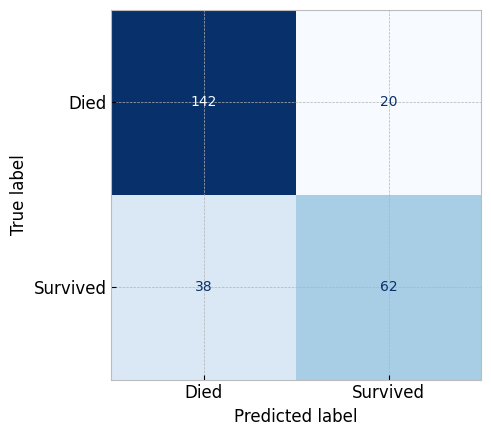

In [131]:
# Then we can plot the confusion matrix
metrics.ConfusionMatrixDisplay.from_estimator(
  estimator=updated_logistic_classifier,
  X=clean_titanic_test_X, y=titanic_test_y,
  display_labels=['Died', 'Survived'],
  cmap="Blues", colorbar=False
)

In [132]:
# And of Course, if we needed to make a prediction on new data points, we can do it like this
## here we're making predictions about 3 records at the same time
new_data = pd.DataFrame({
  'pclass': [1, 2, 3],
  'name': ['John', 'Jane', 'Joe'], # doesn't matter
  'sex': ['male', 'female', 'male'],
  'age': [30, 25, 20],
  'sibsp': [0, 0, 0],
  'parch': [0, 0, 0],
  'ticket': ['123', '456', '789'], # doesn't matter
  'fare': [100, 50, 25],
  'cabin': ['A', 'B', 'C'],
  'embarked': ['S', 'C', 'Q'],
  'boat': ['A', 'B', 'C'], # doesn't matter
  'body': [1, 2, 3], # doesn't matter
  'home.dest': ['London', 'Paris', 'New York'], # doesn't matter
})
# First we need to transform the new data
transformed_new_data = full_pipeline.transform(new_data)
transformed_new_data = pd.DataFrame(transformed_new_data, columns=column_names, index=new_data.index)
clean_new_data = transformed_new_data.drop('sex_female', axis=1).rename(columns={ 'sex_male': 'is_male' })


updated_logistic_classifier.predict(clean_new_data)

array([0, 1, 0])

In [133]:
# Also if we're making a predictions for only one record, we can do it like this
new_data2 = pd.DataFrame.from_records([{
  'pclass': 1,
  'name': 'John', # doesn't matter
  'sex': 'male',
  'age': 25,
  'sibsp': 0,
  'parch': 0,
  'ticket': '123', # doesn't matter
  'fare': 100,
  'cabin': 'A',
  'embarked': 'C',
  'boat': 'A', # doesn't matter; leaked data; will be dropped
  'body': 1, # doesn't matter; leaky data ; will be dropped
  'home.dest': 'London', # doesn't matter - will be removed
}])

# transform the new data
transformed_new_data2 = full_pipeline.transform(new_data2)
transformed_new_data2 = pd.DataFrame(transformed_new_data2, columns=column_names, index=new_data2.index)
clean_new_data2 = transformed_new_data2.drop('sex_female', axis=1).rename(columns={ 'sex_male': 'is_male' })


updated_logistic_classifier.predict(clean_new_data2)


array([1])

This concludes the classification exercise for one algorithm. In the assignment, you'll be asked to do the same with another dataset.

I also encourage you to try the fine-tuning work on this dataset using different algorithms and see how it affects the results. (5 points of extra credit)

## Deploy
The last thing I want to mention is regarding the deployment of the models developed.

Creating web applications or software solutions to house the model would be outside the scope of this course, but that's not the only aspect of deployment.

You may have wondered how do you deploy the model when it's so dependant on the data, and what do you do when the data is millions of records. The answer is that you don't. You deploy the model separately.

The model can be deployed in a variety of ways, and the most common way is to use the pickle library to save the model, and then load it in the application.

[📜 Learn more about this here: Pickle](https://docs.python.org/3/library/pickle.html)



In [134]:
# Deploying the model
pic = pickle.dump(updated_logistic_classifier, file=open('model.pkl', 'wb'))

At any time in the future, if you want to use the model, you can load it, and use it to make predictions.

In [135]:
#load the model 
loaded_model = pickle.load(open('model.pkl', 'rb'))

loaded_model.predict(clean_new_data2)


array([1])